# **KASDD F1 Lap time - Biasa Aja**

# Import Dataset

In [1]:
# import library dan data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



f1_data = pd.read_csv("f1_train.csv")
f1_data = f1_data.drop(axis=1, columns=["ID"])
f1_data

C:\Users\Rizky Prawira N\AppData\Local\Temp\ipykernel_26224\3115078374.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Time,LapTime,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,...,Deleted,DeletedReason,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Pos_cat
0,0 days 02:26:25.496000,0 days 00:01:40.943000,6.0,0 days 02:25:08.325000,NaN,0 days 00:00:46.163000,0 days 00:00:28.979000,0 days 00:00:25.801000,0 days 02:25:36.926000,0 days 02:26:05.905000,...,False,NaN,17.1,68.0,1008.0,False,24.8,157,3.0,Participant
1,0 days 01:13:51.732000,0 days 00:01:48.067000,1.0,NaN,NaN,0 days 00:00:39.129000,0 days 00:00:43.601000,0 days 00:00:25.337000,0 days 01:12:42.794000,0 days 01:13:26.395000,...,False,NaN,25.0,49.0,1008.5,False,43.3,275,1.0,Podium
2,0 days 02:22:35.139000,0 days 00:01:22.881000,2.0,NaN,NaN,0 days 00:00:28.890000,0 days 00:00:18.554000,0 days 00:00:35.437000,0 days 02:21:41.150000,0 days 02:21:59.704000,...,False,NaN,17.6,57.0,1018.2,False,29.9,0,0.6,Participant
3,0 days 01:03:36.822000,0 days 00:01:31.585000,1.0,0 days 00:14:44.885000,NaN,NaN,0 days 00:00:28.929000,0 days 00:00:30.478000,NaN,0 days 01:03:06.412000,...,False,NaN,17.6,67.0,1007.7,False,29.5,135,1.8,Podium
4,0 days 01:45:40.072000,0 days 00:01:34.742000,2.0,NaN,NaN,0 days 00:00:34.895000,0 days 00:00:29.874000,0 days 00:00:29.973000,0 days 01:44:40.174000,0 days 01:45:10.048000,...,False,NaN,26.1,55.0,1011.0,False,31.0,271,1.3,Point
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18783,0 days 01:27:00.913000,0 days 00:01:25.235000,2.0,NaN,NaN,0 days 00:00:30.620000,0 days 00:00:30.668000,0 days 00:00:23.947000,0 days 01:26:06.294000,0 days 01:26:36.962000,...,False,NaN,29.3,32.0,988.4,False,49.9,252,1.2,Participant
18784,0 days 01:21:32.309000,0 days 00:01:40.363000,1.0,NaN,NaN,0 days 00:00:29.488000,0 days 00:00:42.838000,0 days 00:00:28.037000,0 days 01:20:21.469000,0 days 01:21:04.307000,...,False,NaN,30.0,72.0,1009.0,False,36.8,145,1.1,Participant
18785,0 days 02:00:31.678000,0 days 00:01:52.495000,3.0,NaN,NaN,0 days 00:00:32.659000,0 days 00:00:49.567000,0 days 00:00:30.269000,0 days 01:59:11.871000,0 days 02:00:01.438000,...,False,NaN,17.6,66.0,966.7,False,30.3,146,1.1,Participant
18786,0 days 01:07:59.947000,0 days 00:01:25.938000,1.0,NaN,NaN,0 days 00:00:30.564000,0 days 00:00:31.370000,0 days 00:00:24.004000,0 days 01:07:04.556000,0 days 01:07:35.926000,...,False,NaN,28.8,33.0,988.5,False,50.1,134,1.5,Participant


In [2]:
f1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18788 entries, 0 to 18787
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                18788 non-null  object 
 1   LapTime             18498 non-null  object 
 2   Stint               18788 non-null  float64
 3   PitOutTime          1039 non-null   object 
 4   PitInTime           735 non-null    object 
 5   Sector1Time         18381 non-null  object 
 6   Sector2Time         18749 non-null  object 
 7   Sector3Time         18696 non-null  object 
 8   Sector1SessionTime  18344 non-null  object 
 9   Sector2SessionTime  18749 non-null  object 
 10  Sector3SessionTime  18696 non-null  object 
 11  SpeedI1             15871 non-null  float64
 12  SpeedI2             18749 non-null  float64
 13  SpeedFL             18013 non-null  float64
 14  SpeedST             17096 non-null  float64
 15  IsPersonalBest      18758 non-null  object 
 16  Comp

# Preprocessing

In [3]:
def cek_duplicates(df):
    if df.duplicated().sum() > 0:
        print("Terdapat", df.duplicated().sum(), "pasang data yang redundan")
        display(df[df.duplicated()])
    else:
        print("Tidak ada data yang redundan")

def cek_null(df):
    col_na = df.isnull().sum().sort_values(ascending=True)
    percent = col_na*100 / len(df)

    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])

    if (missing_data[missing_data['Total'] > 0].shape[0] == 0):
        print("Tidak ditemukan missing value pada dataset")

    else:
        print(missing_data[missing_data['Total'] > 0])

def cek_outlier(df):
    df_numerical = df.select_dtypes(include=['float64', 'int64']) 
    Q1 = df_numerical.quantile(0.25, numeric_only=True)
    Q3 = df_numerical.quantile(0.75, numeric_only=True)

    # Menghitung RUB dan RLB.
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Menampilkan banyaknya outlier pada atribut.
    outliers = (df_numerical < lower_limit) | (df_numerical > upper_limit)

    # Menghitung dan menampilkan persentase outlier pada tiap atribut.
    percentage_outliers = (outliers.sum() / len(df)) * 100
    print("Persentase Outlier pada tiap atribut:")
    print(percentage_outliers)

### Handling Missing Value

In [4]:
cek_null(f1_data)

                    Total    Percent
IsPersonalBest         30   0.159676
SpeedI2                39   0.207579
Sector2SessionTime     39   0.207579
Sector2Time            39   0.207579
Sector3SessionTime     92   0.489674
Sector3Time            92   0.489674
LapTime               290   1.543538
Sector1Time           407   2.166276
Sector1SessionTime    444   2.363211
SpeedFL               775   4.124973
SpeedST              1692   9.005748
SpeedI1              2917  15.525868
PitOutTime          17749  94.469874
PitInTime           18053  96.087928
DeletedReason       18477  98.344688


> Atribut `PitOutTime`, `PitInTime`, dan `DeletedReason` memiliki persentase jumlah missing value mencapai lebih dari 90%. Oleh karena itu, atribut-atribut tersebut perlu di drop.

In [7]:
f1_data = f1_data.drop(axis=1, columns=['PitOutTime', 'PitInTime', 'DeletedReason'])

In [20]:
def show_data_type_and_distribution(df):
    print("Menampilkan informasi dataset dan tipe data")
    print('#'*50)
    df.info()
    print('#'*50)
    print("Menampilkan distribusi data numerik")
    numerics = ['SpeedI2', 'SpeedFL', 'SpeedST', 'SpeedI1']
    for col in numerics:
        df_feature = f1_data[col]
        plt.figure(figsize=(10,5))
        plt.title(f'Distribusi data {col}')
        sns.kdeplot(df_feature, fill=True)
        plt.show()
    print("Menampilkan Modus dari data kategorikal")
    categoricals = ["IsPersonalBest", "Sector2SessionTime", "Sector2Time","Sector3SessionTime", "Sector3Time", "LapTime", "Sector1Time", "Sector1SessionTime"]
    for col in categoricals:
        print(f"Mode for {col} = {f1_data[col].mode()[0]}")

Menampilkan informasi dataset dan tipe data
##################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18788 entries, 0 to 18787
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                18788 non-null  object 
 1   LapTime             18498 non-null  object 
 2   Stint               18788 non-null  float64
 3   Sector1Time         18381 non-null  object 
 4   Sector2Time         18749 non-null  object 
 5   Sector3Time         18696 non-null  object 
 6   Sector1SessionTime  18344 non-null  object 
 7   Sector2SessionTime  18749 non-null  object 
 8   Sector3SessionTime  18696 non-null  object 
 9   SpeedI1             15871 non-null  float64
 10  SpeedI2             18749 non-null  float64
 11  SpeedFL             18013 non-null  float64
 12  SpeedST             17096 non-null  float64
 13  IsPersonalBest      18758 non-null  object 
 14  Compoun

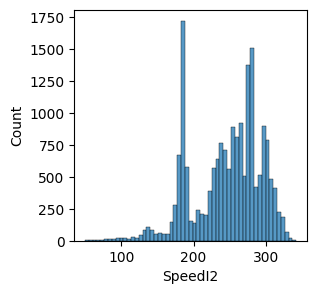

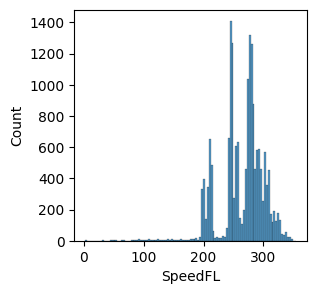

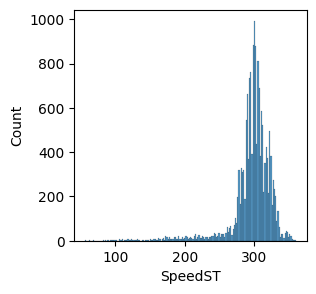

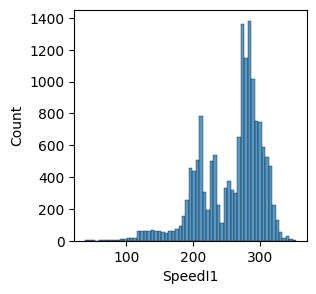

Menampilkan Modus dari data kategorikal
Mode for IsPersonalBest = False
Mode for Sector2SessionTime = 0 days 01:03:29.878000
Mode for Sector2Time = 0 days 00:00:29.905000
Mode for Sector3SessionTime = 0 days 01:06:09.122000
Mode for Sector3Time = 0 days 00:00:25.692000
Mode for LapTime = 0 days 00:01:16.993000
Mode for Sector1Time = 0 days 00:00:28.315000
Mode for Sector1SessionTime = 0 days 01:04:58.279000


In [19]:
show_data_type_and_distribution(f1_data)

In [ ]:
print("Jumlah duplikasi data : " + str(f1_data.duplicated().sum()))

Jumlah duplikasi data : 0


In [ ]:
f1_data = f1_data.drop_duplicates()

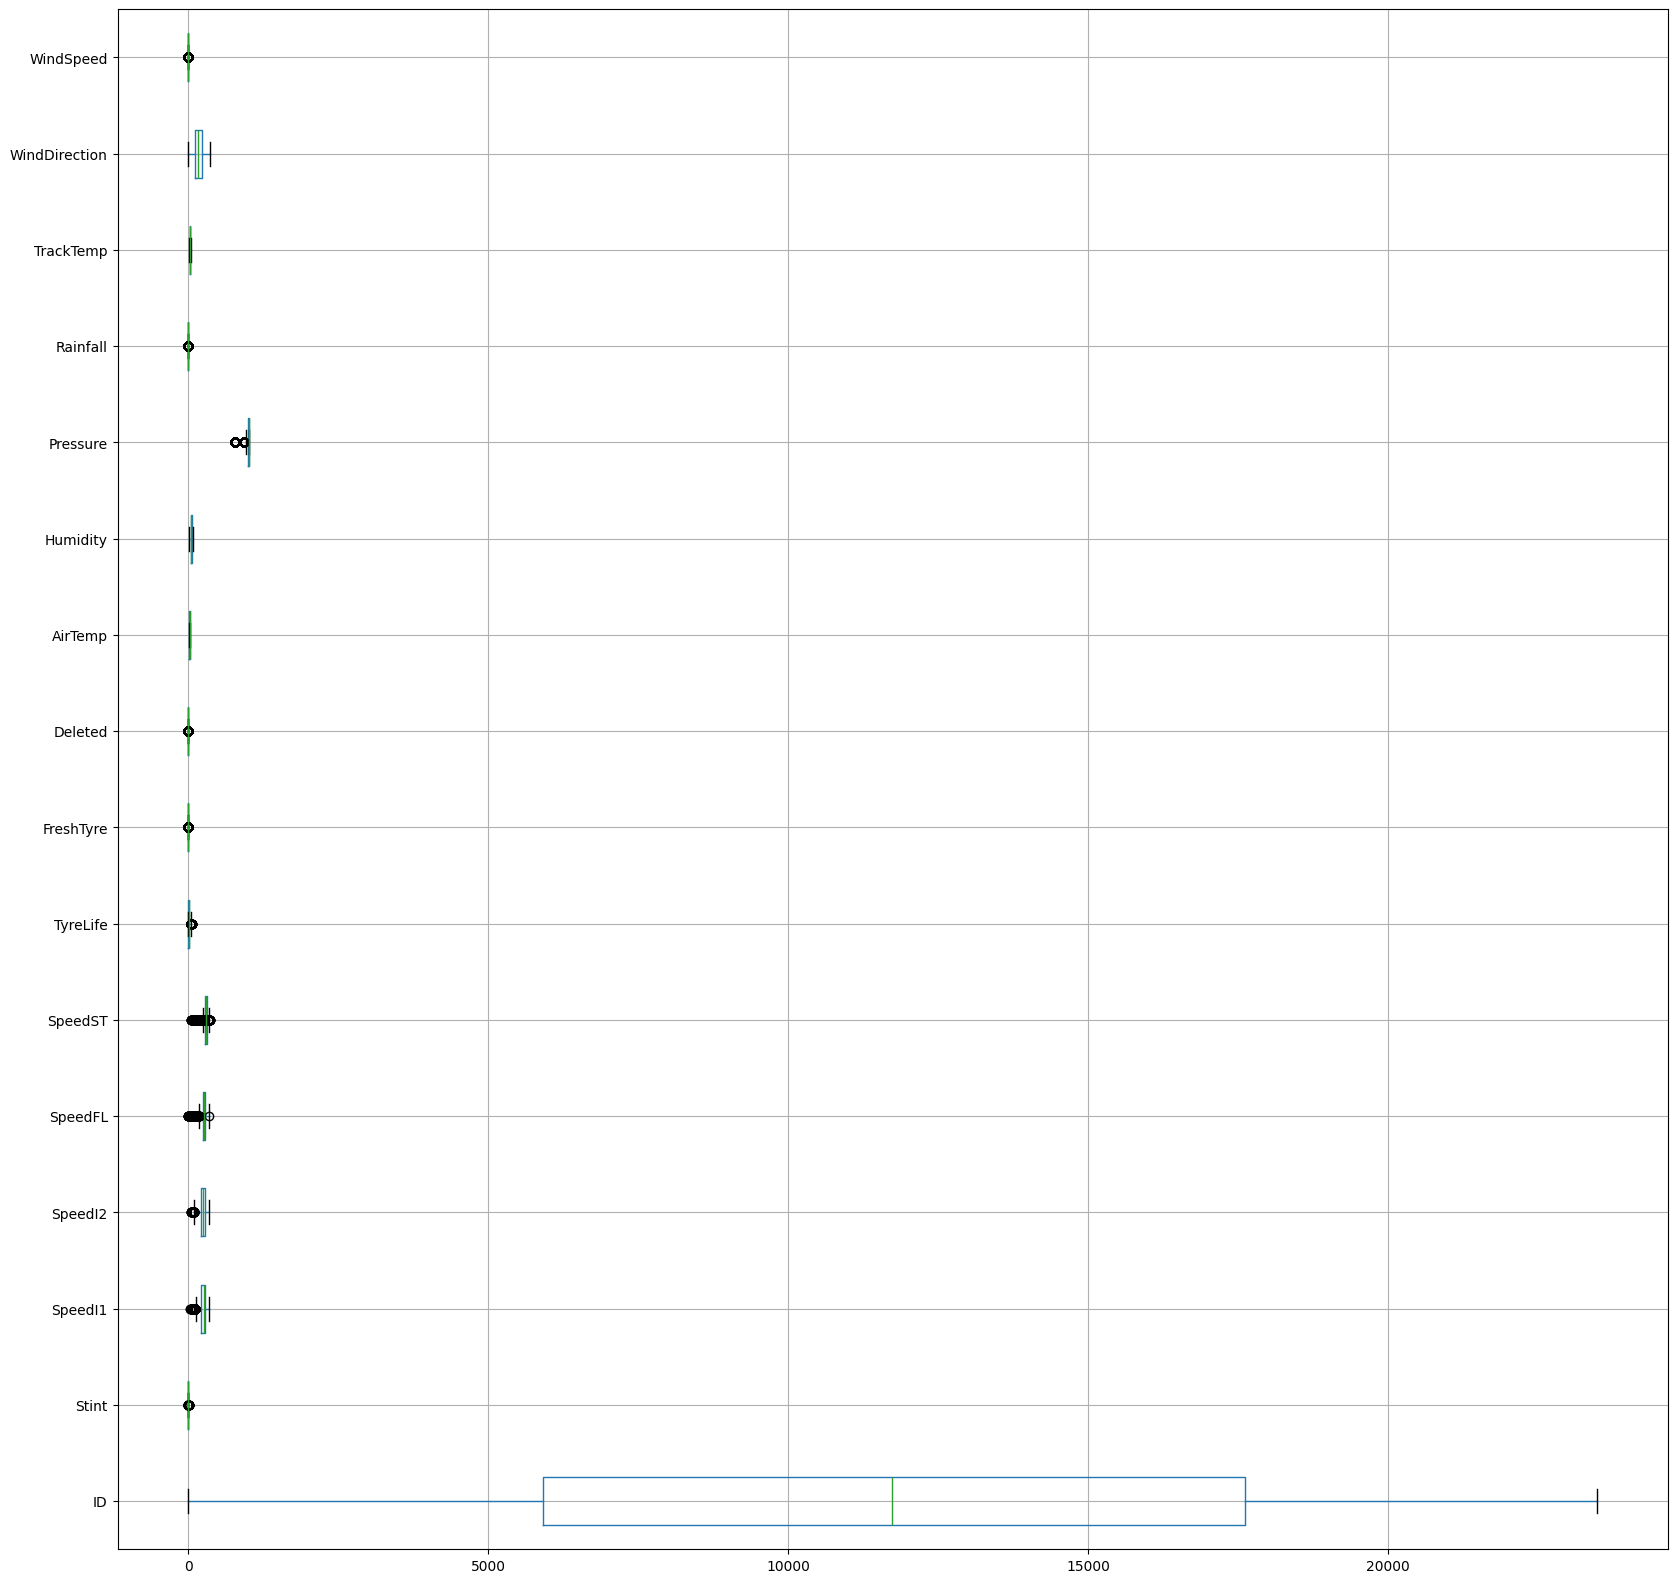

In [ ]:
f1_data.boxplot(vert=False,figsize=(20,20))
plt.show()

In [ ]:
laptime_numerical = f1_data.select_dtypes(include=['float64', 'int64']) 
Q1 = laptime_numerical.quantile(0.25)
Q3 = laptime_numerical.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
print(cek_outlier(f1_data))

               outliers  percentage
Pressure           2974    0.158293
WindSpeed          1508    0.080264
SpeedST            1235    0.065733
TyreLife            366    0.019481
SpeedFL             234    0.012455
SpeedI1             213    0.011337
SpeedI2              94    0.005003
Stint                56    0.002981
ID                    0    0.000000
AirTemp               0    0.000000
Humidity              0    0.000000
TrackTemp             0    0.000000
WindDirection         0    0.000000
